<a href="https://colab.research.google.com/github/niemand-01/ML-Demo/blob/master/GAN_Tensorflow_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
!pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [ ]:
(train_images,train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
# normalize into [-1,1]
train_images = (train_images -127.5)/127.5

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
BUFFER_SIZE=60000
BATCH_SIZE=64

# shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# model

In [ ]:
e

# 如何计算 transpose2d的维度

$X_k$是input dim

$X_{k+1}$是output dim

$k$ 是kernel size

$p$ 是padding

$s$ 是stride

top() 是取顶函数

bottom() 是取底函数

普通正向conv公式计算：

bottom(${X_k-k+2p}\over{s}$)+$1$=$X_{k+1}$

反向convTranspose公式：

$X_k$ = $(X_{k+1}-1)*s-2p+k$

不同padding造成的input-output-dim公式：

valid padding: top(${X_k-k+1}\over{s}$)=$X_{k+1}$

same padding: top(${X_{k}}\over{s}$)=$X_{k+1}$

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  # input shape(100,1)
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  # 实际上的shape(256,7,7) =(channels,rows,cols)
  model.add(layers.Reshape((7,7,256)))

  # no limits on batch_size
  # 4D tensor with shape: (batch_size,rows, cols，channels)
  assert model.output_shape == (None,7,7,256)
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))

  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))

  # 根据上面same padding的公式，反过来是7*2=14
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False))
  
  assert model.output_shape == (None,28,28,1)
  return model

# test image generator

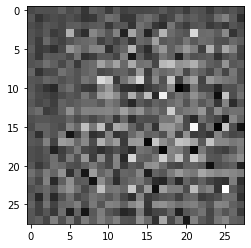

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')

# Discriminator

In [ ]:
def make_discriminiator_model():
  model = tf.keras.Sequential([
      layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]),
      layers.LeakyReLU(),
      layers.Dropout(0.3),
      layers.Conv2D(128,5,2,padding='same'),
      layers.LeakyReLU(),
      layers.Dropout(0.3),
      layers.Flatten(),
      layers.Dense(1)
  ])
  return model

# test discriminator

- if identified as real image, output positive value +
- if identified as fake image, output negative value -

In [ ]:
discriminator = make_discriminiator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00097442]], shape=(1, 1), dtype=float32)


# define Loss and Opitimizer

dicriminator loss = $1||realout$ + $0||fakeout$ realout should be 1

generator loss = $0||fakeout$ fakeout should be 0

By minimizing the Cross-entropy(KL-Divergence) loss, we can optimize the model of correctly classifying the output

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss+fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



# define save checkpoint

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                  discriminator_optimizer=discriminator_optimizer,
                  generator=generator,
                  discriminator=discriminator)

# main train function

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# random seed
seed = tf.random.normal([num_examples_to_generate,noise_dim])

In [ ]:
# train step
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    generated_images = generator(noise,training=True)

    real_output = discriminator(images,training=True)
    fake_output = discriminator(generated_images,training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)

  # get gradients from variable
  gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  # apply gradients to variables(update variables with gradients)
  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [ ]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

    # generate GIF
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch+1,seed)

    # save model
    if (epoch+1)%15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))

  # after final epoch generate image
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

def generate_and_save_images(model,epoch,test_input):
  predictions = model(test_input,training=False)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# train

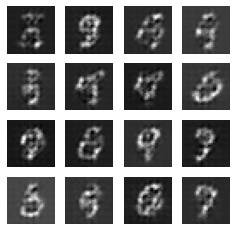

Time for epoch 2 is 730.606495141983 sec


KeyboardInterrupt: ignored

In [ ]:
train(train_dataset,EPOCHS)

# create GIF

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)